In [1]:
%pip install pyarrow==15.0.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### Data Load

In [3]:
# 데이터 분할(폴더) 구분
data_splits = ["train", "test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}


for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        file_path = f"./data/{folder}/{split}_{suffix}.parquet"
        # 변수명 형식: {var_prefix}_{split}_{month}
        variable_name = f"{var_prefix}_{split}"
        globals()[variable_name] = pd.read_parquet(file_path, engine="pyarrow")
        print(f"{variable_name} is loaded from {file_path}")

gc.collect()

customer_train is loaded from ./data/1.회원정보/train_회원정보.parquet
credit_train is loaded from ./data/2.신용정보/train_신용정보.parquet
sales_train is loaded from ./data/3.승인매출정보/train_승인매출정보.parquet
billing_train is loaded from ./data/4.청구입금정보/train_청구정보.parquet
balance_train is loaded from ./data/5.잔액정보/train_잔액정보.parquet
channel_train is loaded from ./data/6.채널정보/train_채널정보.parquet
marketing_train is loaded from ./data/7.마케팅정보/train_마케팅정보.parquet
performance_train is loaded from ./data/8.성과정보/train_성과정보.parquet
customer_test is loaded from ./data/1.회원정보/test_회원정보.parquet
credit_test is loaded from ./data/2.신용정보/test_신용정보.parquet
sales_test is loaded from ./data/3.승인매출정보/test_승인매출정보.parquet
billing_test is loaded from ./data/4.청구입금정보/test_청구정보.parquet
balance_test is loaded from ./data/5.잔액정보/test_잔액정보.parquet
channel_test is loaded from ./data/6.채널정보/test_채널정보.parquet
marketing_test is loaded from ./data/7.마케팅정보/test_마케팅정보.parquet
performance_test is loaded from ./data/8.성과정보/test_성과정보.parquet


0

In [4]:
globals()['credit_train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 42 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   기준년월            400000 non-null  int64  
 1   ID              400000 non-null  object 
 2   최초한도금액          400000 non-null  int64  
 3   카드이용한도금액        400000 non-null  int64  
 4   CA한도금액          400000 non-null  int64  
 5   일시상환론한도금액       400000 non-null  int64  
 6   월상환론한도금액        400000 non-null  int64  
 7   CA이자율_할인전       400000 non-null  float64
 8   CL이자율_할인전       400000 non-null  float64
 9   RV일시불이자율_할인전    400000 non-null  float64
 10  RV현금서비스이자율_할인전  400000 non-null  float64
 11  RV신청일자          74552 non-null   float64
 12  RV약정청구율         400000 non-null  float64
 13  RV최소결제비율        400000 non-null  float64
 14  자발한도감액횟수_R12M   400000 non-null  object 
 15  자발한도감액금액_R12M   400000 non-null  int64  
 16  자발한도감액후경과월      400000 non-null  int64  
 17  강제한도감액횟수_R

### Data Preprocessing(1) : Concat & Merge

In [5]:
# 데이터 유형별 설정 
info_categories = ["customer", "credit", "sales", "billing", "balance", "channel", "marketing", "performance"]

In [6]:
#### Train ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train"]]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


customer_train_df = train_dfs["customer_train_df"]
credit_train_df   = train_dfs["credit_train_df"]
sales_train_df    = train_dfs["sales_train_df"]
billing_train_df  = train_dfs["billing_train_df"]
balance_train_df  = train_dfs["balance_train_df"]
channel_train_df  = train_dfs["channel_train_df"]
marketing_train_df= train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()

customer_train_df is created with shape: (400000, 78)
credit_train_df is created with shape: (400000, 42)
sales_train_df is created with shape: (400000, 406)
billing_train_df is created with shape: (400000, 46)
balance_train_df is created with shape: (400000, 82)
channel_train_df is created with shape: (400000, 105)
marketing_train_df is created with shape: (400000, 64)
performance_train_df is created with shape: (400000, 49)


0

In [7]:
#### Test ####

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test"]]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")


customer_test_df = test_dfs["customer_test_df"]
credit_test_df   = test_dfs["credit_test_df"]
sales_test_df    = test_dfs["sales_test_df"]
billing_test_df  = test_dfs["billing_test_df"]
balance_test_df  = test_dfs["balance_test_df"]
channel_test_df  = test_dfs["channel_test_df"]
marketing_test_df= test_dfs["marketing_test_df"]
performance_test_df = test_dfs["performance_test_df"]

gc.collect()

customer_test_df is created with shape: (100000, 77)
credit_test_df is created with shape: (400000, 42)
sales_test_df is created with shape: (400000, 406)
billing_test_df is created with shape: (400000, 46)
balance_test_df is created with shape: (400000, 82)
channel_test_df is created with shape: (400000, 105)
marketing_test_df is created with shape: (400000, 64)
performance_test_df is created with shape: (400000, 49)


0

In [8]:
#### Train ####

train_df = customer_train_df.merge(credit_train_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: train_step1, shape:", train_df.shape)
del customer_train_df, credit_train_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_train_df",    "Step2"),
    ("billing_train_df",  "Step3"),
    ("balance_train_df",  "Step4"),
    ("channel_train_df",  "Step5"),
    ("marketing_train_df","Step6"),
    ("performance_train_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    train_df = train_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: train_{step}, shape:", train_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: train_step1, shape: (400000, 118)
Step2 저장 완료: train_Step2, shape: (400000, 522)
Step3 저장 완료: train_Step3, shape: (400000, 566)
Step4 저장 완료: train_Step4, shape: (400000, 646)
Step5 저장 완료: train_Step5, shape: (400000, 749)
Step6 저장 완료: train_Step6, shape: (400000, 811)
최종 저장 완료: train_최종, shape: (400000, 858)


In [9]:
#### Test ####

test_df = customer_test_df.merge(credit_test_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: test_step1, shape:", test_df.shape)
del customer_test_df, credit_test_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_test_df",    "Step2"),
    ("billing_test_df",  "Step3"),
    ("balance_test_df",  "Step4"),
    ("channel_test_df",  "Step5"),
    ("marketing_test_df","Step6"),
    ("performance_test_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    test_df = test_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: test_{step}, shape:", test_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: test_step1, shape: (100000, 117)
Step2 저장 완료: test_Step2, shape: (100000, 521)
Step3 저장 완료: test_Step3, shape: (100000, 565)
Step4 저장 완료: test_Step4, shape: (100000, 645)
Step5 저장 완료: test_Step5, shape: (100000, 748)
Step6 저장 완료: test_Step6, shape: (100000, 810)
최종 저장 완료: test_최종, shape: (100000, 857)


# 결측치

In [10]:
missing_percentage = train_df.isnull().sum() / len(train_df) * 100
print("--- 훈련 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])
print(len(missing_percentage[missing_percentage>0]))

--- 훈련 데이터 컬럼별 결측치 비율 (%) ---
가입통신회사코드          15.81875
직장시도명             10.02800
_1순위신용체크구분         1.56025
_2순위신용체크구분        40.22375
최종유효년월_신용_이용가능     9.15225
최종유효년월_신용_이용      23.20175
최종카드발급일자           2.37375
RV신청일자            81.36200
RV전환가능여부           1.92625
_1순위업종            23.62600
_2순위업종            39.26700
_3순위업종            47.33350
_1순위쇼핑업종          39.66000
_2순위쇼핑업종          47.96650
_3순위쇼핑업종          55.15325
_1순위교통업종          49.37975
_2순위교통업종          69.82275
_3순위교통업종          85.89825
_1순위여유업종          87.54850
_2순위여유업종          97.99250
_3순위여유업종          99.66725
_1순위납부업종          51.54600
_2순위납부업종          85.11875
_3순위납부업종          96.35025
최종카드론_금융상환방식코드    81.55950
최종카드론_신청경로코드      81.56300
최종카드론_대출일자        82.84700
연체일자_B0M          99.86450
OS구분코드            68.06525
혜택수혜율_R3M         21.45825
혜택수혜율_B0M         23.43000
dtype: float64
31


In [11]:
missing_percentage = test_df.isnull().sum() / len(test_df) * 100
print("--- 테스트 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])
print(len(missing_percentage[missing_percentage>0]))

--- 테스트 데이터 컬럼별 결측치 비율 (%) ---
가입통신회사코드          15.633
직장시도명             10.457
_1순위신용체크구분         1.816
_2순위신용체크구분        40.268
최종유효년월_신용_이용가능     9.349
최종유효년월_신용_이용      23.043
최종카드발급일자           2.755
RV신청일자            81.362
RV전환가능여부           2.322
_1순위업종            23.467
_2순위업종            39.464
_3순위업종            47.682
_1순위쇼핑업종          39.790
_2순위쇼핑업종          48.040
_3순위쇼핑업종          55.218
_1순위교통업종          49.268
_2순위교통업종          69.948
_3순위교통업종          86.065
_1순위여유업종          89.576
_2순위여유업종          98.442
_3순위여유업종          99.746
_1순위납부업종          51.855
_2순위납부업종          85.425
_3순위납부업종          96.342
최종카드론_금융상환방식코드    81.689
최종카드론_신청경로코드      81.698
최종카드론_대출일자        82.951
연체일자_B0M          99.896
OS구분코드            68.187
혜택수혜율_R3M         21.230
혜택수혜율_B0M         23.235
dtype: float64
31


In [12]:
missing_percentage = train_df.isnull().sum() / len(train_df) * 100
missing_cols = missing_percentage[missing_percentage>0].index
missing_cols

Index(['가입통신회사코드', '직장시도명', '_1순위신용체크구분', '_2순위신용체크구분', '최종유효년월_신용_이용가능',
       '최종유효년월_신용_이용', '최종카드발급일자', 'RV신청일자', 'RV전환가능여부', '_1순위업종', '_2순위업종',
       '_3순위업종', '_1순위쇼핑업종', '_2순위쇼핑업종', '_3순위쇼핑업종', '_1순위교통업종', '_2순위교통업종',
       '_3순위교통업종', '_1순위여유업종', '_2순위여유업종', '_3순위여유업종', '_1순위납부업종', '_2순위납부업종',
       '_3순위납부업종', '최종카드론_금융상환방식코드', '최종카드론_신청경로코드', '최종카드론_대출일자', '연체일자_B0M',
       'OS구분코드', '혜택수혜율_R3M', '혜택수혜율_B0M'],
      dtype='object')

In [13]:
for col in missing_cols:
    print("-------", col, "-------")
    print("unique class:", train_df[col].unique())
    print("unique class number:", len(train_df[col].unique()))
    print("결측치 비율(%):", train_df[col].isnull().sum()/len(train_df)*100)
    print()

------- 가입통신회사코드 -------
unique class: ['L사' 'K사' 'S사' None]
unique class number: 4
결측치 비율(%): 15.818750000000001

------- 직장시도명 -------
unique class: ['서울' '경기' '부산' '강원' '대전' None '인천' '경남' '광주' '충북' '전남' '경북' '울산' '전북'
 '세종' '대구' '충남' '제주']
unique class number: 18
결측치 비율(%): 10.027999999999999

------- _1순위신용체크구분 -------
unique class: ['신용' None '체크']
unique class number: 3
결측치 비율(%): 1.56025

------- _2순위신용체크구분 -------
unique class: ['체크' None '신용']
unique class number: 3
결측치 비율(%): 40.22375

------- 최종유효년월_신용_이용가능 -------
unique class: [202106. 202112. 202103. 202207. 202208. 202006. 202210. 202101. 202303.
     nan 201910. 202202. 202301. 202211. 202012. 202011. 202204. 202104.
 202010. 202312. 202302. 201911. 202008. 202108. 202111. 202205. 202110.
 202007. 202004. 202001. 202305. 202201. 202306. 202403. 202203. 202307.
 202107. 202308. 201909. 201912. 202206. 201906. 202212. 202304. 202109.
 202003. 202309. 202105. 201907. 202311. 201908. 202401. 202209. 202402.
 202102. 202009

In [14]:
train_filled = train_df.copy()
test_filled = test_df.copy()

<Axes: xlabel='count', ylabel='가입통신회사코드'>

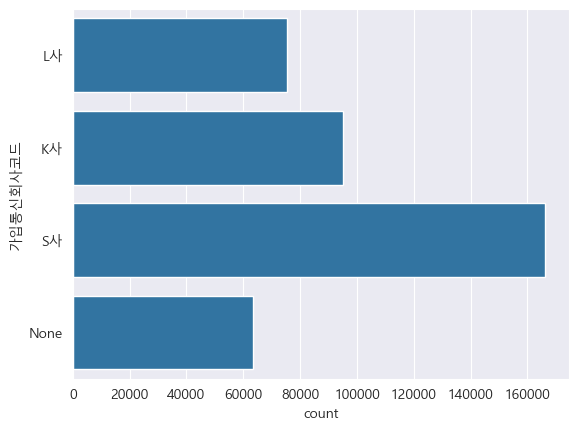

In [15]:
# ------- 가입통신회사코드 -------
# unique class: ['L사' 'K사' 'S사' None]
# unique class number: 4
# 결측치 비율(%): 15.818750000000001

train_filled.loc[train_df["가입통신회사코드"].isnull(), "가입통신회사코드"] = "None"
sns.countplot(train_filled["가입통신회사코드"])

In [16]:
test_filled.loc[test_df["가입통신회사코드"].isnull(), "가입통신회사코드"] = "None"

<Axes: xlabel='count', ylabel='직장시도명'>

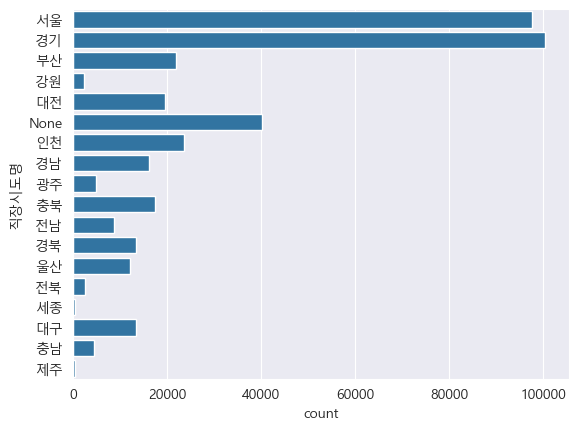

In [17]:
# ------- 직장시도명 -------
# unique class: ['서울' '경기' '부산' '강원' '대전' None '인천' '경남' '광주' '충북' '전남' '경북' '울산' '전북'
#  '세종' '대구' '충남' '제주']
# unique class number: 18
# 결측치 비율(%): 10.027999999999999

train_filled.loc[train_df["직장시도명"].isnull(), "직장시도명"] = "None"
sns.countplot(train_filled["직장시도명"])

In [18]:
test_filled.loc[test_df["직장시도명"].isnull(), "직장시도명"] = "None"

<Axes: xlabel='count', ylabel='_1순위신용체크구분'>

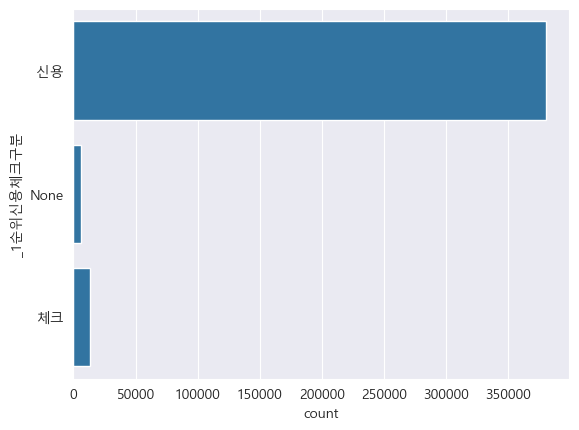

In [19]:
# ------- _1순위신용체크구분 -------
# unique class: ['신용' None '체크']
# unique class number: 3
# 결측치 비율(%): 1.56025

train_filled.loc[train_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "None"
sns.countplot(train_filled["_1순위신용체크구분"])

In [20]:
from scipy.stats import chi2_contingency

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "None"
contingency_table = pd.crosstab(train_filled['_1순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("결측치를 그대로 둘 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "신용"
contingency_table = pd.crosstab(train_filled['_1순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 신용으로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "체크"
contingency_table = pd.crosstab(train_filled['_1순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 체크로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

결측치를 그대로 둘 경우
Chi-square Statistic: 2401.15
P-value: 0.00000

결측치를 신용으로 대체할 경우
Chi-square Statistic: 854.61
P-value: 0.00000

결측치를 체크로 대체할 경우
Chi-square Statistic: 2150.50
P-value: 0.00000


결측치를 그 자체 변수로 둘 경우가 카이제곱 통계량이 가장 큼 -> None 값을 유지할 경우 설명력이 더 높음

In [21]:
train_filled.loc[train_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "None"
test_filled.loc[test_df["_1순위신용체크구분"].isnull(), "_1순위신용체크구분"] = "None"

<Axes: xlabel='count', ylabel='_2순위신용체크구분'>

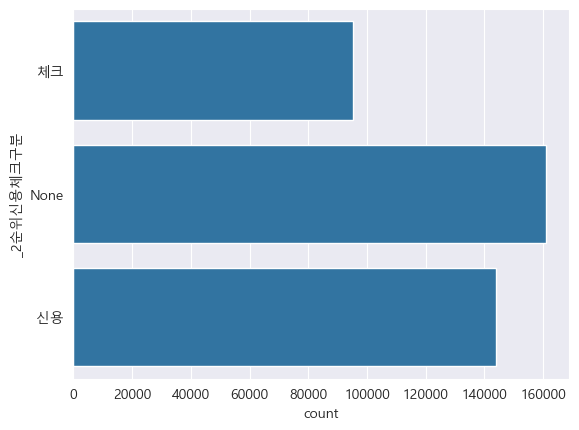

In [22]:
# ------- _2순위신용체크구분 -------
# unique class: ['체크' None '신용']
# unique class number: 3
# 결측치 비율(%): 40.22375

train_filled.loc[train_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "None"
sns.countplot(train_filled["_2순위신용체크구분"])

In [23]:
from scipy.stats import chi2_contingency

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "None"
contingency_table = pd.crosstab(train_filled['_2순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("결측치를 그대로 둘 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "신용"
contingency_table = pd.crosstab(train_filled['_2순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 신용으로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "체크"
contingency_table = pd.crosstab(train_filled['_2순위신용체크구분'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 체크로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

결측치를 그대로 둘 경우
Chi-square Statistic: 25454.17
P-value: 0.00000

결측치를 신용으로 대체할 경우
Chi-square Statistic: 397.93
P-value: 0.00000

결측치를 체크로 대체할 경우
Chi-square Statistic: 22407.35
P-value: 0.00000


In [24]:
train_filled.loc[train_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "None"
test_filled.loc[test_df["_2순위신용체크구분"].isnull(), "_2순위신용체크구분"] = "None"

<Axes: xlabel='최종유효년월_신용_이용가능', ylabel='Count'>

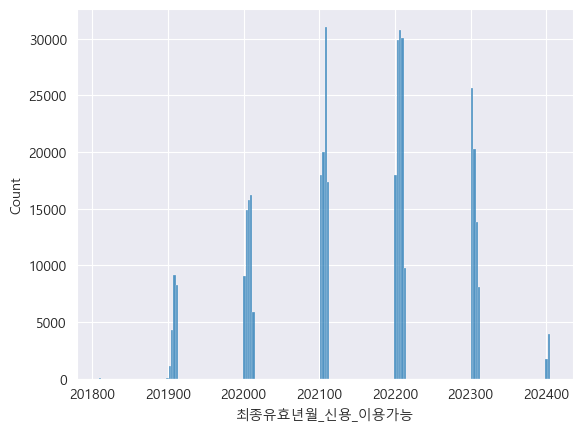

In [25]:
# ------- 최종유효년월_신용_이용가능 -------
# unique class: [202106. 202112. 202103. 202207. 202208. 202006. 202210. 202101. 202303.
#      nan 201910. 202202. 202301. 202211. 202012. 202011. 202204. 202104.
#  202010. 202312. 202302. 201911. 202008. 202108. 202111. 202205. 202110.
#  202007. 202004. 202001. 202305. 202201. 202306. 202403. 202203. 202307.
#  202107. 202308. 201909. 201912. 202206. 201906. 202212. 202304. 202109.
#  202003. 202309. 202105. 201907. 202311. 201908. 202401. 202209. 202402.
#  202102. 202009. 201902. 202005. 202310. 202002. 202405. 201905. 202404.
#  201903. 201904. 201901. 201810. 201811. 201812. 201809.]
# unique class number: 70
# 결측치 비율(%): 9.15225

sns.histplot(train_filled["최종유효년월_신용_이용가능"])

- 실제 날짜가 소수로 표현된 상태임 -> 특정 날짜(이 데이터에서는 `기준년월`을 기준으로 함)로부터의 상대적인 차이로 변환하는 것이 좋아보임

In [26]:
def date2months(base_date, target):
    base_year = base_date//100
    base_month = base_date%100
    target_year = target//100
    target_month = target%100
    return (target_month+12*target_year)-(base_month+12*base_year)

<Axes: xlabel='최종유효년월_신용_이용가능', ylabel='Count'>

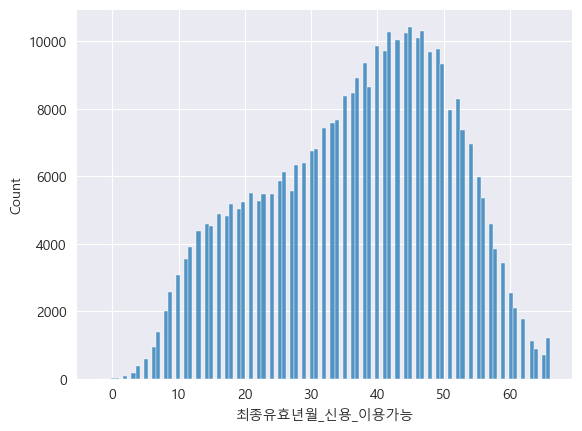

In [27]:
train_filled["최종유효년월_신용_이용가능"] = date2months(train_df['기준년월'], train_df['최종유효년월_신용_이용가능'])
sns.histplot(train_filled["최종유효년월_신용_이용가능"])

- 전체 분포가 대칭적이지 않고, 결측치 비율이 높지 않음 -> 중앙값으로 대체
- 결측치를 채우게 되면 그 부분에 집중됨, 그리고 원래 결측치였던 부분의 정보를 유지하기 위해 새로운 피처`최종유효년월_신용_이용가능_is_missing`를 추가

In [28]:
train_filled.loc[train_df["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능"] = train_filled["최종유효년월_신용_이용가능"].median()
test_filled.loc[test_df["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능"] = train_filled["최종유효년월_신용_이용가능"].median()

In [29]:
train_filled['최종유효년월_신용_이용가능_is_missing'] = 0
test_filled['최종유효년월_신용_이용가능_is_missing'] = 0
train_filled.loc[train_df["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능_is_missing"] = 1
test_filled.loc[test_df["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능_is_missing"] = 1

<Axes: xlabel='최종유효년월_신용_이용가능', ylabel='Count'>

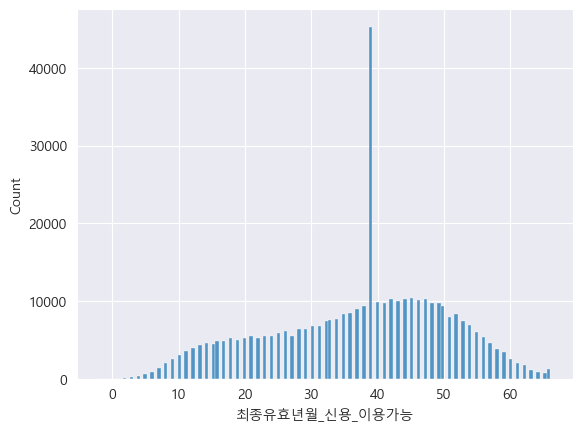

In [30]:
sns.histplot(train_filled["최종유효년월_신용_이용가능"])

<Axes: xlabel='최종유효년월_신용_이용', ylabel='Count'>

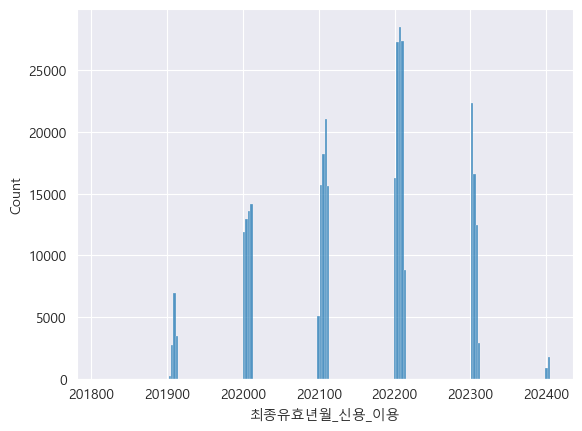

In [31]:
# ------- 최종유효년월_신용_이용 -------
# unique class: [202108. 202202. 202201.     nan 202210. 202104. 202301. 202006. 202207.
#  202212. 202211. 202101. 202205. 202105. 202102. 202305. 201912. 202004.
#  202112. 202111. 202012. 202008. 202209. 202109. 202010. 202107. 202208.
#  202206. 202303. 202204. 202005. 202403. 202203. 202110. 202001. 202302.
#  202402. 201910. 201908. 202007. 202106. 202304. 202103. 202308. 202009.
#  202309. 202311. 202306. 202011. 201906. 201909. 201907. 202401. 202003.
#  202312. 202310. 202002. 201911. 202405. 202307. 202404. 201905. 201903.
#  201902. 201904. 201901. 201810. 201811. 201812.]
# unique class number: 69
# 결측치 비율(%): 23.201749999999997

sns.histplot(train_filled["최종유효년월_신용_이용"])

일단 연속형 변수로 변환

<Axes: xlabel='최종유효년월_신용_이용', ylabel='Count'>

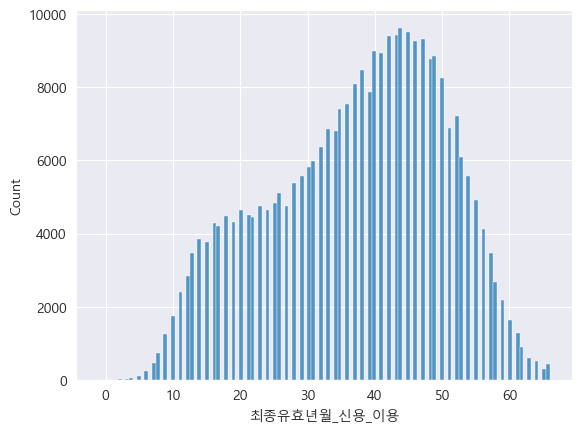

In [32]:
train_filled["최종유효년월_신용_이용"] = date2months(train_df['기준년월'], train_df['최종유효년월_신용_이용'])
sns.histplot(train_filled["최종유효년월_신용_이용"])

결측치 비율이 높음(20% 이상) -> 이 변수를 제거할지 결정하기 위해 타겟변수와 통계 검정 필요함(분산분석)

In [33]:
from scipy import stats

def run_anova_test(data_series, target_series):
    # 타겟 그룹별로 연속형 데이터를 리스트에 저장
    groups = [data_series[target_series == seg].dropna() for seg in target_series.unique()]
    
    # 그룹 내 분산이 충분한지 확인 (ANOVA의 기본 가정)
    if any(len(g) < 2 for g in groups):
        return np.nan, np.nan # 그룹 크기가 너무 작으면 NaN 반환

    # ANOVA 검정 수행
    f_statistic, p_value = stats.f_oneway(*groups)
    return f_statistic, p_value

In [34]:
# -------------------------------------------------------------
# 1. 시나리오 A: 단순 중앙값 대체 (Baseline)
# -------------------------------------------------------------
df_temp_a = train_filled.copy()
feature_col = '최종유효년월_신용_이용' # 실제 피처 이름으로 변경하세요
target_col = 'Segment' # 실제 타겟 이름으로 변경하세요

median_val = df_temp_a[feature_col].median()
df_temp_a.loc[df_temp_a[feature_col].isnull(), feature_col] = median_val

f_a, p_a = run_anova_test(df_temp_a[feature_col], df_temp_a[target_col])
print(f"1. 단순 중앙값 대체: F-Statistic = {f_a:.2f}, P-value = {p_a:.5f}")

# -------------------------------------------------------------
# 3. 시나리오 C: 결측치 지시 변수 추가 (결측치 정보의 연관성 검정)
# -------------------------------------------------------------
# 결측 여부 변수 생성 (0/1)
df_temp_c = train_filled.copy()
df_temp_c['missing_indicator'] = df_temp_c[feature_col].isnull().astype(int)

# 3-1. 원본 피처 (중앙값 대체 후) 연관성 검정
df_temp_c.loc[df_temp_c[feature_col].isnull(), feature_col] = median_val
f_c_orig, p_c_orig = run_anova_test(df_temp_c[feature_col], df_temp_c[target_col])

# 3-2. 'missing_indicator' 변수의 연관성 검정 (ANOVA 또는 Chi2)
# 'missing_indicator'는 이진 변수이므로 Chi2 검정이 더 적합함.
contingency_table_missing = pd.crosstab(df_temp_c['missing_indicator'], df_temp_c[target_col])
chi2_c_miss, p_c_miss, _, _ = stats.chi2_contingency(contingency_table_missing)

print(f"3-1. 지시 변수 추가 후 원본 피처: F-Statistic = {f_c_orig:.2f}, P-value = {p_c_orig:.5f}")
print(f"3-2. 결측 지시 변수 자체: Chi2 = {chi2_c_miss:.2f}, P-value = {p_c_miss:.5f}")

1. 단순 중앙값 대체: F-Statistic = 629.56, P-value = 0.00000
3-1. 지시 변수 추가 후 원본 피처: F-Statistic = 629.56, P-value = 0.00000
3-2. 결측 지시 변수 자체: Chi2 = 16068.96, P-value = 0.00000


결측치인지 확인하는 변수의 설명력이 높음

In [35]:
train_filled.loc[train_df["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용"] = train_filled["최종유효년월_신용_이용"].median()
test_filled.loc[test_df["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용"] = train_filled["최종유효년월_신용_이용"].median()
train_filled['최종유효년월_신용_이용_is_missing'] = 0
test_filled['최종유효년월_신용_이용_is_missing'] = 0
train_filled.loc[train_df["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용_is_missing"] = 1
test_filled.loc[test_df["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용_is_missing"] = 1

<Axes: xlabel='최종카드발급일자', ylabel='Count'>

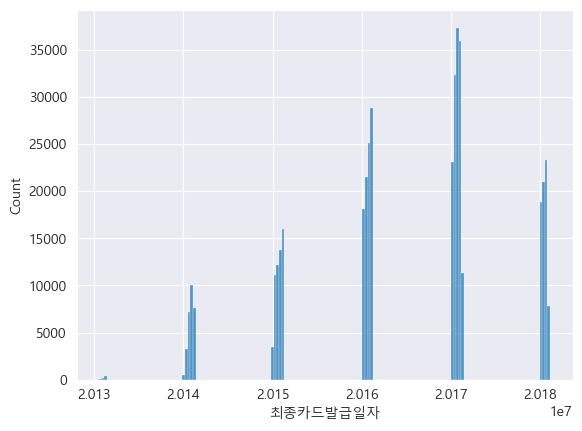

In [36]:
# ------- 최종카드발급일자 -------
# unique class: [20160912. 20170122. 20161113. ... 20130923. 20130701. 20130813.]
# unique class number: 1909
# 결측치 비율(%): 2.3737500000000002


sns.histplot(train_df["최종카드발급일자"])

In [37]:
train_df["최종카드발급일자"].unique()

array([20160912., 20170122., 20161113., ..., 20130923., 20130701.,
       20130813.])

In [38]:
def date2months2(base_date, date):
    base_year = base_date//100
    base_month = base_date%100
    date_year = date//10000
    date_month = (date//100)%100
    return 12*(base_year-date_year)+base_month-date_month

<Axes: xlabel='최종카드발급일자', ylabel='Count'>

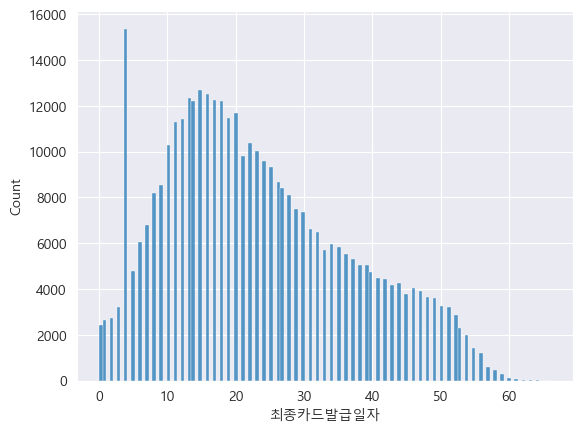

In [39]:
train_filled["최종카드발급일자"] = date2months2(train_df['기준년월'], train_df['최종카드발급일자'])
sns.histplot(train_filled["최종카드발급일자"])

In [40]:
train_filled["최종카드발급일자"].mode()

0    4.0
Name: 최종카드발급일자, dtype: float64

In [41]:
train_filled.loc[train_df["최종카드발급일자"].isnull(), "최종카드발급일자"] = train_filled["최종카드발급일자"].median()
test_filled.loc[test_df["최종카드발급일자"].isnull(), "최종카드발급일자"] = train_filled["최종카드발급일자"].median()
train_filled['최종카드발급일자_is_missing'] = 0
test_filled['최종카드발급일자_is_missing'] = 0
train_filled.loc[train_df["최종카드발급일자"].isnull(), "최종카드발급일자_is_missing"] = 1
test_filled.loc[test_df["최종카드발급일자"].isnull(), "최종카드발급일자_is_missing"] = 1
train_filled['최종카드발급일자_4'] = 0
test_filled['최종카드발급일자_4'] = 0
train_filled.loc[train_df["최종카드발급일자"] == 4, "최종카드발급일자_4"] = 1
test_filled.loc[test_df["최종카드발급일자"] == 4, "최종카드발급일자_4"] = 1

<Axes: xlabel='RV신청일자', ylabel='Count'>

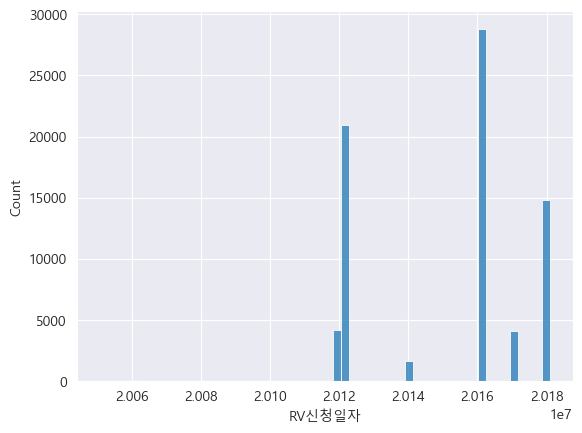

In [42]:
# ------- RV신청일자 -------
# unique class: [      nan 20180206. 20120712. ... 20140224. 20121123. 20180318.]
# unique class number: 1104
# 결측치 비율(%): 81.362

sns.histplot(train_df["RV신청일자"])

결측치 비율이 너무 높음 -> 결측치인지 아닌지 확인하는 이진 변수로 변환

In [43]:
train_filled = train_filled.drop(columns=["RV신청일자"])
test_filled = test_filled.drop(columns=["RV신청일자"])
train_filled['RV신청일자_is_missing'] = 0
test_filled['RV신청일자_is_missing'] = 0
train_filled.loc[train_df["RV신청일자"].isnull(), "RV신청일자_is_missing"] = 1
test_filled.loc[test_df["RV신청일자"].isnull(), "RV신청일자_is_missing"] = 1

<Axes: xlabel='RV전환가능여부', ylabel='Count'>

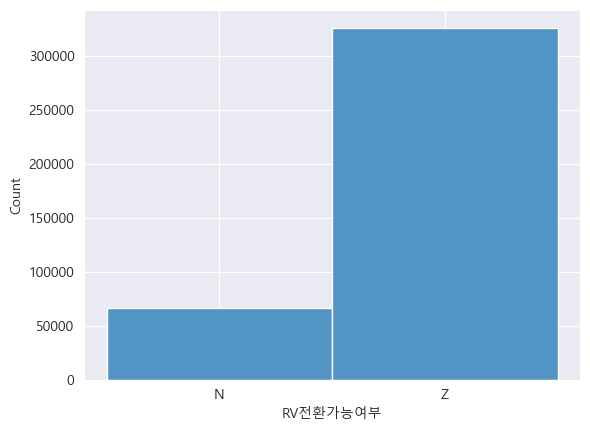

In [44]:
# ------- RV전환가능여부 -------
# unique class: ['N' 'Z' None]
# unique class number: 3
# 결측치 비율(%): 1.9262499999999998

sns.histplot(train_df["RV전환가능여부"])

In [45]:
# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["RV전환가능여부"].isnull(), "RV전환가능여부"] = "None"
contingency_table = pd.crosstab(train_filled['RV전환가능여부'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("결측치를 그대로 둘 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["RV전환가능여부"].isnull(), "RV전환가능여부"] = "N"
contingency_table = pd.crosstab(train_filled['RV전환가능여부'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 N으로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["RV전환가능여부"].isnull(), "RV전환가능여부"] = "Z"
contingency_table = pd.crosstab(train_filled['RV전환가능여부'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("\n결측치를 Z로 대체할 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

결측치를 그대로 둘 경우
Chi-square Statistic: 2279.86
P-value: 0.00000

결측치를 N으로 대체할 경우
Chi-square Statistic: 211.83
P-value: 0.00000

결측치를 Z로 대체할 경우
Chi-square Statistic: 752.08
P-value: 0.00000


In [46]:
train_filled.loc[train_df["RV전환가능여부"].isnull(), "RV전환가능여부"] = "None"
test_filled.loc[test_df["RV전환가능여부"].isnull(), "RV전환가능여부"] = "None"

<Axes: xlabel='count', ylabel='_1순위업종'>

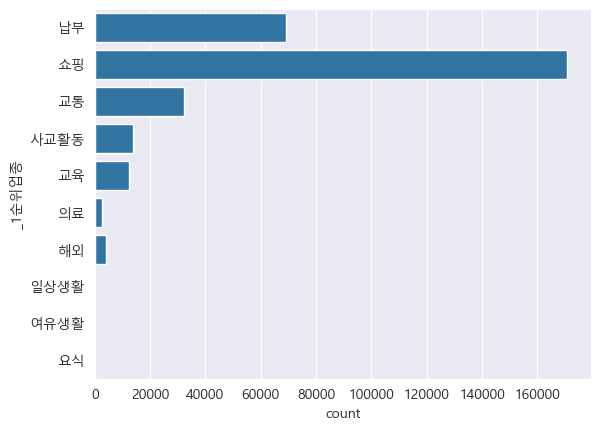

In [47]:
# ------- _1순위업종 -------
# unique class: ['납부' '쇼핑' None '교통' '사교활동' '교육' '의료' '해외' '일상생활' '여유생활' '요식']
# unique class number: 11
# 결측치 비율(%): 23.626


sns.countplot(train_df['_1순위업종'])

In [48]:
# 타겟 변수와 피처로 교차표 생성
# train_filled.loc[train_df["_1순위업종"].isnull(), "RV전환가능여부"] = "None"
contingency_table = pd.crosstab(train_filled['_1순위업종'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("결측치를 그대로 둘 경우")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

# 타겟 변수와 피처로 교차표 생성
train_filled.loc[train_df["_1순위업종"].isnull(), "_1순위업종"] = "None"
contingency_table = pd.crosstab(train_filled['_1순위업종'], train_filled['Segment'])

# 카이제곱 검정 수행
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 결과 확인
print("결측치 'None'으로 대체")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_value:.5f}") 
# P-value가 0.05보다 작으면, 두 변수 간에 통계적 연관성이 있다고 결론 내릴 수 있습니다.

결측치를 그대로 둘 경우
Chi-square Statistic: 17643.95
P-value: 0.00000
결측치 'None'으로 대체
Chi-square Statistic: 36854.74
P-value: 0.00000


In [49]:
train_filled.loc[train_df["_1순위업종"].isnull(), "_1순위업종"] = "None"
test_filled.loc[test_df["_1순위업종"].isnull(), "_1순위업종"] = "None"

In [50]:
# ------- _2순위업종 -------
# unique class: ['쇼핑' '사교활동' None '교통' '납부' '해외' '의료' '교육' '여유생활' '일상생활' '요식']
# unique class number: 11
# 결측치 비율(%): 39.267

train_filled.loc[train_df["_2순위업종"].isnull(), "_2순위업종"] = "None"
test_filled.loc[test_df["_2순위업종"].isnull(), "_2순위업종"] = "None"

In [51]:
# ------- _3순위업종 -------
# unique class: ['일상생활' '교통' '사교활동' None '납부' '쇼핑' '여유생활' '해외' '의료' '요식' '교육']
# unique class number: 11
# 결측치 비율(%): 47.3335


train_filled.loc[train_df["_3순위업종"].isnull(), "_3순위업종"] = "None"
test_filled.loc[test_df["_3순위업종"].isnull(), "_3순위업종"] = "None"

In [52]:
# ------- _1순위쇼핑업종 -------
# unique class: [None '도소매' '온라인' '마트' '슈퍼마켓' '편의점' '백화점' '쇼핑기타' '아울렛']
# unique class number: 9
# 결측치 비율(%): 39.660000000000004


train_filled.loc[train_df["_1순위쇼핑업종"].isnull(), "_1순위쇼핑업종"] = "None"
test_filled.loc[test_df["_1순위쇼핑업종"].isnull(), "_1순위쇼핑업종"] = "None"

In [53]:
# ------- _2순위쇼핑업종 -------
# unique class: [None '온라인' '도소매' '슈퍼마켓' '마트' '편의점' '쇼핑기타' '백화점' '아울렛']
# unique class number: 9
# 결측치 비율(%): 47.9665

train_filled.loc[train_df["_2순위쇼핑업종"].isnull(), "_2순위쇼핑업종"] = "None"
test_filled.loc[test_df["_2순위쇼핑업종"].isnull(), "_2순위쇼핑업종"] = "None"

In [54]:
# ------- _3순위쇼핑업종 -------
# unique class: [None '슈퍼마켓' '마트' '편의점' '도소매' '쇼핑기타' '백화점' '아울렛' '온라인']
# unique class number: 9
# 결측치 비율(%): 55.15325

train_filled.loc[train_df["_3순위쇼핑업종"].isnull(), "_3순위쇼핑업종"] = "None"
test_filled.loc[test_df["_3순위쇼핑업종"].isnull(), "_3순위쇼핑업종"] = "None"

In [55]:
# ------- _1순위교통업종 -------
# unique class: ['택시' '주유' None '버스지하철' '정비' '철도버스']
# unique class number: 6
# 결측치 비율(%): 49.37975


train_filled.loc[train_df["_1순위교통업종"].isnull(), "_1순위교통업종"] = "None"
test_filled.loc[test_df["_1순위교통업종"].isnull(), "_1순위교통업종"] = "None"

In [56]:
# ------- _2순위교통업종 -------
# unique class: [None '정비' '버스지하철' '택시' '철도버스' '주유' '통행료']
# unique class number: 7
# 결측치 비율(%): 69.82275


train_filled.loc[train_df["_2순위교통업종"].isnull(), "_2순위교통업종"] = "None"
test_filled.loc[test_df["_2순위교통업종"].isnull(), "_2순위교통업종"] = "None"

In [57]:
# ------- _3순위교통업종 -------
# unique class: [None '택시' '정비' '버스지하철' '철도버스']
# unique class number: 5
# 결측치 비율(%): 85.89825


train_filled.loc[train_df["_3순위교통업종"].isnull(), "_3순위교통업종"] = "None"
test_filled.loc[test_df["_3순위교통업종"].isnull(), "_3순위교통업종"] = "None"

In [58]:
# ------- _1순위여유업종 -------
# unique class: [None '운동' '여유기타' '공연' '숙박' 'Pet' '공원' '항공']
# unique class number: 8
# 결측치 비율(%): 87.54849999999999


train_filled.loc[train_df["_1순위여유업종"].isnull(), "_1순위여유업종"] = "None"
test_filled.loc[test_df["_1순위여유업종"].isnull(), "_1순위여유업종"] = "None"

In [59]:
# ------- _2순위여유업종 -------
# unique class: [None '숙박' '공연' '여유기타' 'Pet' '공원' '운동']
# unique class number: 7
# 결측치 비율(%): 97.9925

train_filled.loc[train_df["_2순위여유업종"].isnull(), "_2순위여유업종"] = "None"
test_filled.loc[test_df["_2순위여유업종"].isnull(), "_2순위여유업종"] = "None"

In [60]:
# ------- _3순위여유업종 -------
# unique class: [None '공연' '여유기타' '숙박' 'Pet' '공원']
# unique class number: 6
# 결측치 비율(%): 99.66725


train_filled.loc[train_df["_3순위여유업종"].isnull(), "_3순위여유업종"] = "None"
test_filled.loc[test_df["_3순위여유업종"].isnull(), "_3순위여유업종"] = "None"

In [61]:
# ------- _1순위납부업종 -------
# unique class: ['보험료' '통신비' None '관리비' '가스/전기료' '납부기타']
# unique class number: 6
# 결측치 비율(%): 51.54600000000001


train_filled.loc[train_df["_1순위납부업종"].isnull(), "_1순위납부업종"] = "None"
test_filled.loc[test_df["_1순위납부업종"].isnull(), "_1순위납부업종"] = "None"

In [62]:
# ------- _2순위납부업종 -------
# unique class: ['납부기타' None '통신비' '가스/전기료' '보험료' '관리비']
# unique class number: 6
# 결측치 비율(%): 85.11875

train_filled.loc[train_df["_2순위납부업종"].isnull(), "_2순위납부업종"] = "None"
test_filled.loc[test_df["_2순위납부업종"].isnull(), "_2순위납부업종"] = "None"

In [63]:
# ------- _3순위납부업종 -------
# unique class: [None '납부기타' '보험료' '통신비' '가스/전기료']
# unique class number: 5
# 결측치 비율(%): 96.35025

train_filled.loc[train_df["_3순위납부업종"].isnull(), "_3순위납부업종"] = "None"
test_filled.loc[test_df["_3순위납부업종"].isnull(), "_3순위납부업종"] = "None"

In [64]:
# ------- 최종카드론_금융상환방식코드 -------
# unique class: [nan  5.  2.  3.]
# unique class number: 4
# 결측치 비율(%): 81.5595


train_filled.loc[train_df["최종카드론_금융상환방식코드"].isnull(), "최종카드론_금융상환방식코드"] = 1.
test_filled.loc[test_df["최종카드론_금융상환방식코드"].isnull(), "최종카드론_금융상환방식코드"] = 1.

In [65]:
# ------- 최종카드론_신청경로코드 -------
# unique class: [None '8' '7' '1' 'D' '2']
# unique class number: 6
# 결측치 비율(%): 81.563

train_filled.loc[train_df["최종카드론_신청경로코드"].isnull(), "최종카드론_신청경로코드"] = "None"
test_filled.loc[test_df["최종카드론_신청경로코드"].isnull(), "최종카드론_신청경로코드"] = "None"

<Axes: xlabel='최종카드론_대출일자', ylabel='Count'>

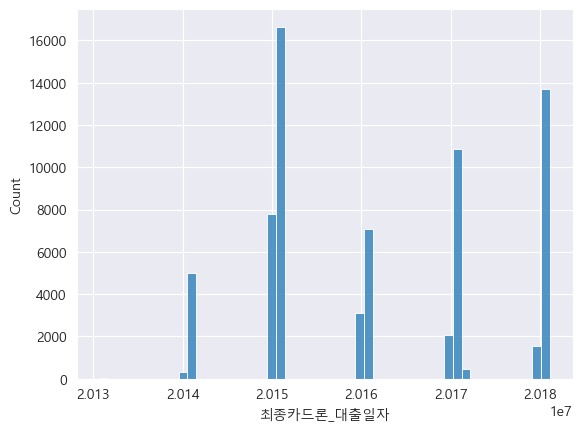

In [66]:
# ------- 최종카드론_대출일자 -------
# unique class: [      nan 20170327. 20151119. ... 20140119. 20140130. 20140215.]
# unique class number: 1666
# 결측치 비율(%): 82.84700000000001


sns.histplot(train_df["최종카드론_대출일자"])

In [67]:
train_filled["최종카드론_대출일자_is_missing"] = 0
test_filled["최종카드론_대출일자_is_missing"] = 0
train_filled.loc[train_df["최종카드론_대출일자"].isnull(), "최종카드론_대출일자_is_missing"] = 1
test_filled.loc[test_df["최종카드론_대출일자"].isnull(), "최종카드론_대출일자_is_missing"] = 1
train_filled = train_filled.drop(columns=["최종카드론_대출일자"])
test_filled = test_filled.drop(columns=["최종카드론_대출일자"])

In [68]:
# ------- 연체일자_B0M -------
# unique class: [      nan 20180917. 20180916. 20180902. 20180821. 20180830. 20180831.
#  20180828. 20180910. 20180913. 20180826. 20180824. 20180901. 20180817.
#  20180818. 20180908. 20180829. 20180825. 20180827. 20180905. 20180819.
#  20180903. 20180822. 20180915. 20180904. 20180823. 20180912. 20180805.
#  20180911. 20180907. 20180914. 20180909. 20180820. 20180906. 20180816.
#  20180921. 20180926. 20180815. 20180924. 20180920. 20180813. 20180918.
#  20180814. 20180919.]
# unique class number: 44
# 결측치 비율(%): 99.8645

train_filled["연체일자_B0M_is_missing"] = 0
test_filled["연체일자_B0M_is_missing"] = 0
train_filled.loc[train_df["연체일자_B0M"].isnull(), "연체일자_B0M_is_missing"] = 1
test_filled.loc[test_df["연체일자_B0M"].isnull(), "연체일자_B0M_is_missing"] = 1
train_filled = train_filled.drop(columns=["연체일자_B0M"])
test_filled = test_filled.drop(columns=["연체일자_B0M"])

In [69]:
# ------- OS구분코드 -------
# unique class: ['Android' None 'IOS']
# unique class number: 3
# 결측치 비율(%): 68.06525


train_filled.loc[train_df["OS구분코드"].isnull(), "OS구분코드"] = "None"
test_filled.loc[test_df["OS구분코드"].isnull(), "OS구분코드"] = "None"

<Axes: xlabel='혜택수혜율_R3M', ylabel='Count'>

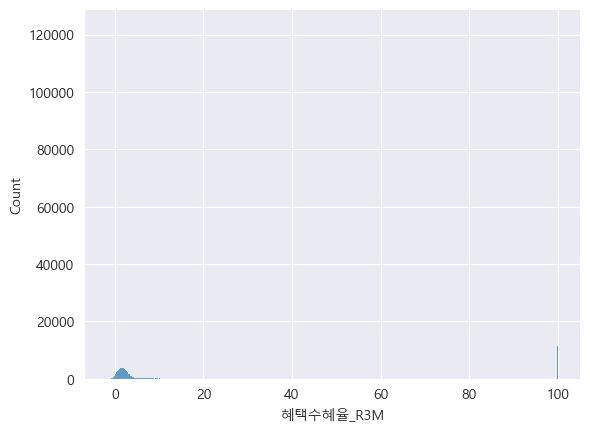

In [70]:
# ------- 혜택수혜율_R3M -------
# unique class: [0.93772247 0.         0.49679363 ... 2.40491202 2.39440674 1.98824829]
# unique class number: 180883
# 결측치 비율(%): 21.45825


sns.histplot(train_df["혜택수혜율_R3M"])

In [71]:
train_df["혜택수혜율_R3M"].mode()

0    0.0
Name: 혜택수혜율_R3M, dtype: float64

In [72]:
print(len(train_df.loc[train_df["혜택수혜율_R3M"] == 0]))
print(len(train_df.loc[train_df["혜택수혜율_R3M"] == 99.9998]))

121312
11498


<Axes: xlabel='혜택수혜율_R3M', ylabel='Count'>

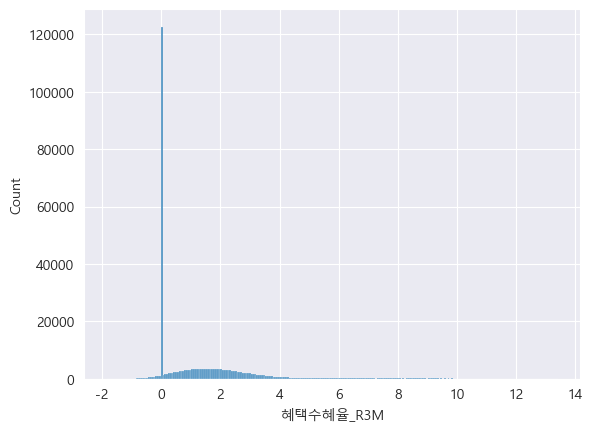

In [73]:
sns.histplot(train_df.loc[train_df["혜택수혜율_R3M"] < 99.9998, "혜택수혜율_R3M"])

99.9998이랑 0에 비정상적으로 몰려있음

<Axes: xlabel='혜택수혜율_R3M', ylabel='Count'>

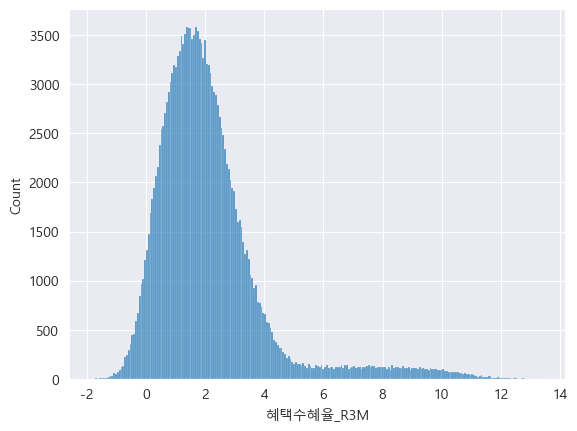

In [74]:
sns.histplot(train_df.loc[(train_df["혜택수혜율_R3M"] < 99.9998) & (train_df["혜택수혜율_R3M"] != 0), "혜택수혜율_R3M"])

0과 99.9998을 제외한 나머지 데이터들의 분포

In [75]:
print("0:", len(train_df.loc[train_df["혜택수혜율_R3M"] == 0, "혜택수혜율_R3M"]))
print("99.998:", len(train_df.loc[train_df["혜택수혜율_R3M"] == 99.9998, "혜택수혜율_R3M"]))
print("결측치:", len(train_df.loc[train_df["혜택수혜율_R3M"].isnull()]))
print("나머지:",len(train_df.loc[(train_df["혜택수혜율_R3M"] < 99.9998) & (train_df["혜택수혜율_R3M"] != 0), "혜택수혜율_R3M"]))

0: 121312
99.998: 11498
결측치: 85833
나머지: 181357


- 이렇게 4개 클래스로 구분하는 범주형 데이터로 변환
- 결측치는 정확히 어디에 존재할지 모르니까 -1로 대체, 0은 0, 나머지는 1, 99.9998은 가장 크니까 2로 라벨링

In [76]:
train_filled.loc[(train_df["혜택수혜율_R3M"] < 99.9998) & (train_df["혜택수혜율_R3M"] != 0), "혜택수혜율_R3M"] = 1
train_filled.loc[train_df["혜택수혜율_R3M"] == 99.9998, "혜택수혜율_R3M"] = 2
train_filled.loc[train_df["혜택수혜율_R3M"].isnull(), "혜택수혜율_R3M"] = -1
## 0은 그대로 둠

test_filled.loc[(test_df["혜택수혜율_R3M"] < 99.9998) & (test_df["혜택수혜율_R3M"] != 0), "혜택수혜율_R3M"] = 1
test_filled.loc[test_df["혜택수혜율_R3M"] == 99.9998, "혜택수혜율_R3M"] = 2
test_filled.loc[test_df["혜택수혜율_R3M"].isnull(), "혜택수혜율_R3M"] = -1
## 0은 그대로 둠

<Axes: xlabel='혜택수혜율_B0M', ylabel='Count'>

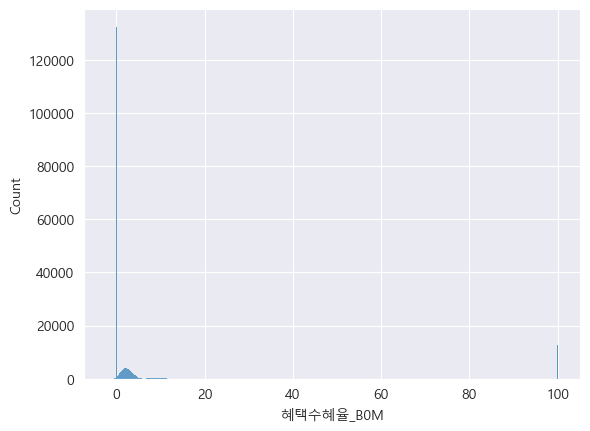

In [77]:
# ------- 혜택수혜율_B0M -------
# unique class: [ 1.47896476  0.         -0.21872811 ...  2.20340267  1.90523529
#   2.13084216]
# unique class number: 161402
# 결측치 비율(%): 23.43

sns.histplot(train_df["혜택수혜율_B0M"])

<Axes: xlabel='혜택수혜율_B0M', ylabel='Count'>

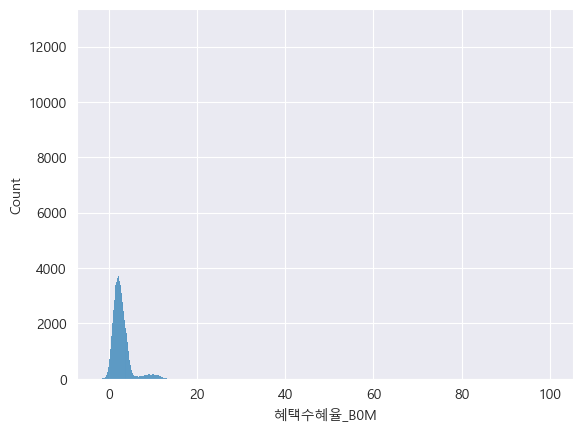

In [78]:
sns.histplot(train_df.loc[train_df["혜택수혜율_B0M"] != 0, "혜택수혜율_B0M"])

In [79]:
train_df.loc[train_df["혜택수혜율_B0M"] != 0, "혜택수혜율_B0M"].mode()

0    99.9998
Name: 혜택수혜율_B0M, dtype: float64

<Axes: xlabel='혜택수혜율_B0M', ylabel='Count'>

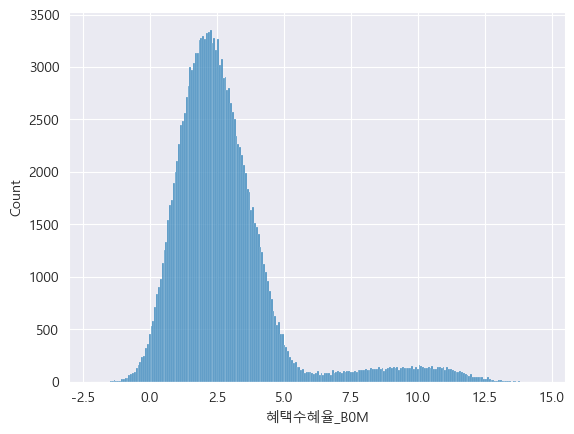

In [80]:
sns.histplot(train_df.loc[(train_df["혜택수혜율_B0M"] != 0) & (train_df["혜택수혜율_B0M"] != 99.9998), "혜택수혜율_B0M"]) 

In [81]:
train_filled.loc[(train_df["혜택수혜율_B0M"] < 99.9998) & (train_df["혜택수혜율_B0M"] != 0), "혜택수혜율_B0M"] = 1
train_filled.loc[train_df["혜택수혜율_B0M"] == 99.9998, "혜택수혜율_B0M"] = 2
train_filled.loc[train_df["혜택수혜율_B0M"].isnull(), "혜택수혜율_B0M"] = -1
## 0은 그대로 둠

test_filled.loc[(test_df["혜택수혜율_B0M"] < 99.9998) & (test_df["혜택수혜율_B0M"] != 0), "혜택수혜율_B0M"] = 1
test_filled.loc[test_df["혜택수혜율_B0M"] == 99.9998, "혜택수혜율_B0M"] = 2
test_filled.loc[test_df["혜택수혜율_B0M"].isnull(), "혜택수혜율_B0M"] = -1
## 0은 그대로 둠

In [82]:
missing_percentage = train_filled.isnull().sum() / len(train_filled) * 100
print("--- 훈련 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])
print(len(missing_percentage[missing_percentage>0]))

--- 훈련 데이터 컬럼별 결측치 비율 (%) ---
Series([], dtype: float64)
0


---
# 날짜형 데이터 전처리

In [83]:
train_df = train_filled.copy()

# 숫자 값 가지는 데이터 분류
continous_columns = []
for col in train_filled.columns:
    if pd.api.types.is_numeric_dtype(train_filled[col]):
        continous_columns.append(col)
print(continous_columns)

['기준년월', '남녀구분코드', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비할인카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '카드신청건수', '최종카드발급경과월', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', '

In [84]:
gc.collect()

# 날짜 YYYYMM 형태의 값을 갖는 컬럼은 기준년월 밖에 없음; 기준년월은 상수이므로 나중에 변수 유형 분리할 때 제거

is_year = (train_filled[continous_columns] // 100 > 1980).all(axis=0) & (train_filled[continous_columns] // 100 < 2030).all(axis=0)
is_month = (train_filled[continous_columns] % 100 >= 1).all(axis=0) & (train_filled[continous_columns] % 100 <= 12).all(axis=0)
is_date = is_year & is_month

print("YYYYMM 형태의 데이터:", is_date.sum(), is_date[is_date].index.tolist())


# 날짜 YYYYMMDD 형태의 값을 갖는 컬럼은 입회일자 신용 밖에 없음

is_year = (train_filled[continous_columns] // 10000 > 1980).all(axis=0) & (train_filled[continous_columns] // 10000 < 2030).all(axis=0)
is_month = (train_filled[continous_columns] % 10000 % 100 >= 1).all(axis=0) & (train_filled[continous_columns] % 10000 % 100 <= 12).all(axis=0)
is_date = is_year & is_month

print("YYYYMMDD 형태의 데이터:", is_date.sum(), is_date[is_date].index.tolist())

del is_year
del is_month
del is_date
del continous_columns
gc.collect()

YYYYMM 형태의 데이터: 1 ['기준년월']
YYYYMMDD 형태의 데이터: 1 ['입회일자_신용']


0

20180601


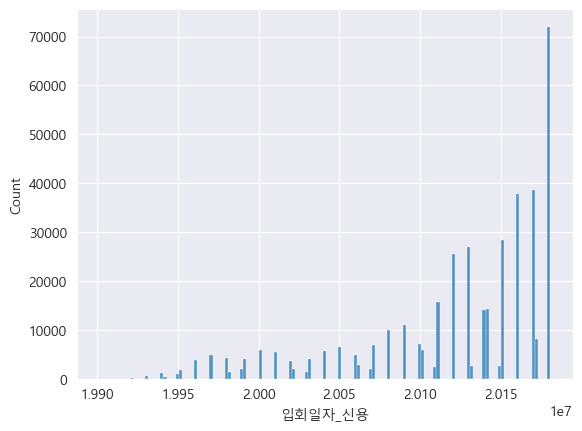

In [85]:
# 입회 일자 신용 전처리
sns.histplot(train_filled["입회일자_신용"])
print(train_filled["입회일자_신용"].max())

In [86]:
def date2days(base_date, target):
    days_month = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334] # 계산 편의상 평년으로 가정
    base_year = base_date//10000
    base_month = base_date % 10000 // 100
    base_day = base_date % 100
    target_year = target // 10000
    target_month = target % 10000 // 100
    target_day = target % 100
    return (base_day + days_month[base_month-1] + base_year*365)-(target_day + days_month[target_month-1] + target_year*365)

train_filled["입회일자_신용"] = train_df.apply(
    lambda row: date2days(row['기준년월']*100, row['입회일자_신용']), axis=1)
test_filled["입회일자_신용"] = test_df.apply(
    lambda row: date2days(row['기준년월']*100, row['입회일자_신용']), axis=1)

152


231

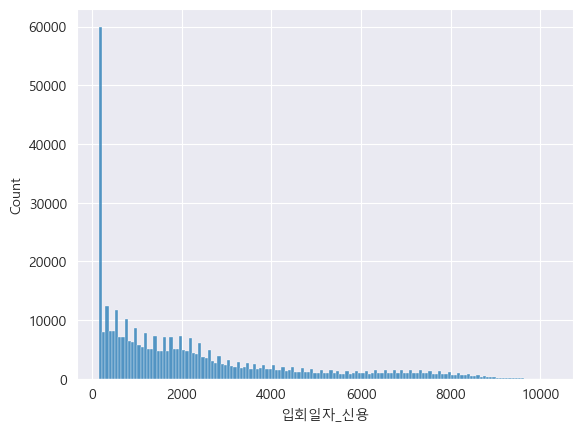

In [87]:
sns.histplot(train_filled["입회일자_신용"])
print(train_filled["입회일자_신용"].min())

del train_df
gc.collect()

---
# 피처 엔지니어링

### 가정(가설)
숫자형 독립변수 간에 날짜가 중복되는 변수 존재    
ex: 이용금액_할부_유이자 (최근 12개월간), 이용금액_할부_유이자 (최근 6개월간) -> 6개월이 중복 됨.    

만약 최근 6개월간의 수치가 최근 12개월 수치보다 압도적으로 높으면 6개월 이전의 값이 무의미해져서 상관관계가 매우 높게 나올 수 있음(다중선신경 발생)   
따라서, 중복되는 독립변수 간에 뺄셈을 통해, 독립변수 끼리의 중복성을 제거 ex: (최근 12개월간 ~ 변수) - (최근 6개월간 ~ 변수) -> (12개월 이전 부터 6개월 이전까지의 독립된 피쳐 생성)   

### 검증 방법
1. 가정을 통해 새롭게 만든 변수가 타겟 변수에 유의미한지 검증 -> ANOVA 검증 (XGBoost는 선형관계가 아니므로 검정단계에서 탈락시키는건 좋지 않음)   
2. 머신러닝 방식의 검증:   
        i. 피처 엔지니어링 된 데이터로 모델 학습 후 피처링 된 변수가 특성 중요도 상위권에 있는지 확인   
        ii. 피처 엔지니어링 없이 학습한 모델 A와 피처 엔지니어링 있이 학습한 모델 B의 F1 점수 비교 -> 유의미한 성능 상승이 있는지 확인 (교차검증)   

In [88]:
continous_cols = []
categorical_cols = []

for col in train_filled.columns:
    if train_filled[col].nunique() == 1:
        train_filled.drop(col, axis=1, inplace=True)
    elif train_filled[col].nunique() > 50:
        continous_cols.append(col)
    else:
        categorical_cols.append(col)

print('연속형 데이터:', continous_cols)

연속형 데이터: ['ID', '입회일자_신용', '입회경과개월수_신용', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '최종카드발급경과월', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV약정청구율', '카드이용한도금액_B1M', '카드이용한도금액_B2M', 'rv최초시작후경과일', '최종이용일자_기본', '최종이용일자_신판', '최종이용일자_CA', '최종이용일자_카드론', '최종이용일자_체크', '최종이용일자_일시불', '최종이용일자_할부', '이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_체크_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_할부_유이자_B0M', '이용금액_할부_무이자_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M', '이용건수_신용_R12M', '이용건수_신판_R12M', '이용건수_일시불_R12M', '이용건수_할부_R12M', '이용건수_할부_무이자_R12M', '이용건수_체크_R12M', '이용금액_일시불_R12M', '이용금액_할부_R12M', '이용금액_할부_유이자_R12M', '이용금액_할부_무이자_R12M', '이용금액_부분무이자_R12M', '이용금액_CA_R12M', '이용금액_체크_R12M', '이용금액_카드론_R12M', '최대이용금액_일시불_R12M', '최대이용금액_할부_R12M', '최대이용금액_할부_유이자_R12M', '최대이용금액_할부_무이자_R12M', '최대이용금액_부분무이자_R12M', '최대이용금액_

### 변수 키워드별 의미

시점 관계 키워드 (변화량 확인)

* 전월
* B0 : 당월
* B0M : 당월
* B1M : 1개월 전
* B2M : 2개월 전
* B3M : 3개월 전
* B4M : 4개월 전
* B5M : 5개월 전

중복성 있는 키워드 (뻴셈 처리)
* R12M : 최근 1년간 (12개월)
* R6M : 최근 6개월간
* R3M : 최근 3개월간
* r6m : 최근 6개월간
* r3m : 최근 3개월간

애매한 키워드 -> 중복되는 걸로 가정.

* 3M : 최근 3개월
* 6M : 최근 6개월
   
중복성 없는 키워드   


* 3M_R12M : 최근 1년 3개월 이하
* 6M_R12M : 최근 1년 4~6개월
* 12M_R12M : 최근 1년 7~12개월
* 14M_R12M : 최근 1년 12개월 이상

In [89]:
# 전처리가 필요한 column들 추출
column_family = {}

# 중복 키워드
overlapping_keys = [
    '전월', 'B0', 'B0M', 'B1M', 'B2M', 'B3M', 'B4M', 'B5M', 'R12M',
    'R6M', 'R3M', '6M', '3M', 'r6m', 'r3m'
]

non_overlapping_keys = [
    '3M_R12M' ,'6M_R12M', '12M_R12M', '14M_R12M'
]

# B3M, R3M을 3M 으로 해석하는 걸 막기 위해 길이 순으로 정렬.
overlapping_keys.sort(key=len, reverse=True)

for col_name in continous_cols:
    is_good_feat = False
    for good_key in non_overlapping_keys:
        if good_key in col_name:
            is_good_feat = True
            break
    
    if is_good_feat:
        continue
    
    found_key = ""
    base_prefix = ""
    
    for key in overlapping_keys:
        
        if key in col_name:
            base_prefix = col_name.replace(key, "")
            found_key = key
            break
        
    if not found_key:
        continue
        
    if base_prefix not in column_family:
        column_family[base_prefix] = {}
        
    column_family[base_prefix][found_key] = col_name
    
        
for base_prefix, family_members in column_family.copy().items():
    if len(family_members) <= 1:
        del column_family[base_prefix]


In [90]:
cnt = 0

for name, members in column_family.items():
    print(name, members.keys()); cnt+=len(members.keys())
    
print(cnt)

del cnt
del overlapping_keys 
del non_overlapping_keys

gc.collect()

카드이용한도금액_ dict_keys(['B1M', 'B2M'])
이용건수_신용_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용건수_신판_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용건수_일시불_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용건수_체크_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_일시불_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_할부_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_할부_유이자_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_할부_무이자_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_CA_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_체크_ dict_keys(['B0M', 'R12M', 'R6M', 'R3M'])
이용금액_부분무이자_ dict_keys(['R12M', 'R6M'])
이용금액_카드론_ dict_keys(['R12M', 'R6M'])
이용금액_온라인_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_오프라인_ dict_keys(['R6M', 'R3M', 'B0M'])
이용건수_오프라인_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_페이_온라인_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_페이_오프라인_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_간편결제_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_A페이_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_B페이_ dict_keys(['R6M', 'R3M', 'B0M'])
이용금액_C페이_ dict_keys(['R6

23558

## 조합별 처리 과정

### 뺄셈 진행
* R?M(r?m) 만 있는 조합 -> 단순히 R12M에서 R6M을 빼면 됨.
* 3M, 6M 조합 -> 6M이 3M을 포함하니 뺄쎔
* B0M(B0), R?M 조합 -> R6M에서 R3M을 빼고 R3M에서 B0M을 빼야함.

### 중복 특성 제거 또는 변화량 변수 생성
* B?M만 있는 조합 -> 시점값이므로 (?달 차이) 변화량 변수 생성 가능. 시점별 기간이 짧으므로 잘못하면 아예 같은 값이 나올 수도 있음. 따라서 최신값만 살려놓고 나머지는 차분(변화량)으로 채워넣기

즉 과정은 뻴셈으로 모두 똑같다.

In [91]:
# 전처리 코드(피쳐 엔지니어링)

train_engineered = train_filled.copy()
test_engineered = test_filled.copy()

# 피쳐링된 df, 피쳐링 된 칼럼 출력
def feature_engineering(df):
    
    # 기간의 순서 정의 (뼬셈 자동화를 위해 사용)
    TIME_ORDER_KEYS = [
        'R12M', 'R6M', '6M', 'r6m', 
        'R3M', '3M', 'r3m', 
        'B5M', 'B4M', 'B3M', 'B2M', 'B1M', 
        'B0M', 'B0'
    ]
    
    engineered_coloumns = []

    for base_prefix, members in column_family.items():
        
        keys_in_family = set(members.keys())
        
        # 뻴셈을 정확한 순서로 하기 위한 정렬
        sorted_keys = [key for key in TIME_ORDER_KEYS if key in keys_in_family]
        
        for i in range(len(sorted_keys)-1):
            train_engineered[base_prefix+sorted_keys[i]] = train_filled[base_prefix+sorted_keys[i]]-train_filled[base_prefix+sorted_keys[i+1]]
            engineered_coloumns.append(base_prefix+sorted_keys[i])
    return df, engineered_coloumns

train_engineered, engineered_coloumns = feature_engineering(train_engineered)
test_engineered, _ = feature_engineering(test_engineered)

del column_family
gc.collect()

0

In [92]:
print(engineered_coloumns)

['카드이용한도금액_B2M', '이용건수_신용_R12M', '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_신판_R12M', '이용건수_신판_R6M', '이용건수_신판_R3M', '이용건수_일시불_R12M', '이용건수_일시불_R6M', '이용건수_일시불_R3M', '이용건수_체크_R12M', '이용건수_체크_R6M', '이용건수_체크_R3M', '이용금액_일시불_R12M', '이용금액_일시불_R6M', '이용금액_일시불_R3M', '이용금액_할부_R12M', '이용금액_할부_R6M', '이용금액_할부_R3M', '이용금액_할부_유이자_R12M', '이용금액_할부_유이자_R6M', '이용금액_할부_유이자_R3M', '이용금액_할부_무이자_R12M', '이용금액_할부_무이자_R6M', '이용금액_할부_무이자_R3M', '이용금액_CA_R12M', '이용금액_CA_R6M', '이용금액_CA_R3M', '이용금액_체크_R12M', '이용금액_체크_R6M', '이용금액_체크_R3M', '이용금액_부분무이자_R12M', '이용금액_카드론_R12M', '이용금액_온라인_R6M', '이용금액_온라인_R3M', '이용금액_오프라인_R6M', '이용금액_오프라인_R3M', '이용건수_오프라인_R6M', '이용건수_오프라인_R3M', '이용금액_페이_온라인_R6M', '이용금액_페이_온라인_R3M', '이용금액_페이_오프라인_R6M', '이용금액_페이_오프라인_R3M', '이용금액_간편결제_R6M', '이용금액_간편결제_R3M', '이용금액_A페이_R6M', '이용금액_A페이_R3M', '이용금액_B페이_R6M', '이용금액_B페이_R3M', '이용금액_C페이_R6M', '이용금액_C페이_R3M', '이용금액_D페이_R6M', '이용금액_D페이_R3M', '이용금액_선결제_R6M', '이용금액_선결제_R3M', '이용건수_선결제_R6M', '이용금액_연체_R6M', '이용금액_연체_R3M', '가맹점매출금액_B2M', '정상청구원금_B5M', '정상청구원금_B2

In [93]:
# Segment랑 선형성이 있는지 검증(참고만)

from sklearn.feature_selection import f_classif

F_stats, p_values = f_classif(train_engineered[engineered_coloumns], train_engineered['Segment'])

result = pd.DataFrame({
    'Variable': engineered_coloumns,
    'F_statistic': F_stats,
    'p_value': p_values
})

print(result)

non_corr = result[result['p_value'] > 0.05]['Variable'].tolist()
print("탈락 후보:", non_corr) # 참고만 하기

del non_corr
del F_stats, p_values
gc.collect()


               Variable   F_statistic        p_value
0          카드이용한도금액_B2M     52.360997   3.594669e-44
1          이용건수_신용_R12M  33515.582317   0.000000e+00
2           이용건수_신용_R6M  22843.504304   0.000000e+00
3           이용건수_신용_R3M  25041.047057   0.000000e+00
4          이용건수_신판_R12M  32880.281742   0.000000e+00
..                  ...           ...            ...
104           평잔_카드론_6M    135.638380  5.014803e-116
105    잔액_신판평균한도소진율_r6m     25.194712   6.755755e-21
106    잔액_신판최대한도소진율_r6m   2002.177600   0.000000e+00
107  잔액_신판ca평균한도소진율_r6m     62.284929   1.036231e-52
108  잔액_신판ca최대한도소진율_r6m   2595.167318   0.000000e+00

[109 rows x 3 columns]
탈락 후보: ['가맹점매출금액_B2M', '잔액_일시불_B2M']


0

---
# 상관계수 분석

1. 숫자형 vs 숫자형   
        * 피어슨 상관계수를 구한 후, 절댓값을 씌워 계수가 0.98이 넘는 쌍을 선택.   
        * 종속변수 Segment와 ANOVA 검정을 통해 한 쌍의 두 개의 데이터 중, F-value가 낮은 독립 변수 탈락.   
           
2. 범주형 vs 범주형   
        * Phik 를 구한 후, 계수가 0.98이 넘는 쌍 선택.   
        * 종속변수 Segment와 카이제곱 검정을 통해 카이제곱 통계량이 낮은 독립 변수 탈락.   
        * 추가) Phik 구하는데 컴퓨터 메모리 부족, 시간 너무 오래 걸려서 라벨링 후, corr 상관계수 추출 후, 카이제곱분포 적용   

3. 범주형 vs 숫자형   
        * Phik로 계수 구하고 어떤 독립변수 조합이 관련성이 강한지 알 수 있음.   
        * 하지만 서로 다른형의 독립변수는 종속변수(Segment)의 검정통계량 범위가 다르기 때문에 검정통계량만으로 선택 불가능.   
        * 따라서 비용이 많이 들고, 독립변수 간의 조합도 매우 많기 때문에 현실적으로 불가능. XGBoost의 능력을 믿고 상관계수 제거 안함.

### 1. 변수 유형 분리

In [94]:
# 상관계수 추출하는데 쓰이는 df 초기화
train_dropped_orig = train_filled.copy()
train_dropped_featured = train_engineered.copy()

print('연속형 데이터:', continous_cols)
print('범주형 데이터:', categorical_cols)

연속형 데이터: ['ID', '입회일자_신용', '입회경과개월수_신용', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '최종카드발급경과월', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV약정청구율', '카드이용한도금액_B1M', '카드이용한도금액_B2M', 'rv최초시작후경과일', '최종이용일자_기본', '최종이용일자_신판', '최종이용일자_CA', '최종이용일자_카드론', '최종이용일자_체크', '최종이용일자_일시불', '최종이용일자_할부', '이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_체크_B0M', '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_할부_유이자_B0M', '이용금액_할부_무이자_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M', '이용건수_신용_R12M', '이용건수_신판_R12M', '이용건수_일시불_R12M', '이용건수_할부_R12M', '이용건수_할부_무이자_R12M', '이용건수_체크_R12M', '이용금액_일시불_R12M', '이용금액_할부_R12M', '이용금액_할부_유이자_R12M', '이용금액_할부_무이자_R12M', '이용금액_부분무이자_R12M', '이용금액_CA_R12M', '이용금액_체크_R12M', '이용금액_카드론_R12M', '최대이용금액_일시불_R12M', '최대이용금액_할부_R12M', '최대이용금액_할부_유이자_R12M', '최대이용금액_할부_무이자_R12M', '최대이용금액_부분무이자_R12M', '최대이용금액_

In [95]:
del train_dropped_orig['ID']
del train_dropped_orig['Segment']

del train_dropped_featured['ID']
del train_dropped_featured['Segment']

continous_cols.remove('ID')
categorical_cols.remove('Segment')

### 2. 숫자형 vs 숫자형 상관관계 분석
* 상관관계가 0.98이상인 독립변수 추출
* 추출된 상관계수의 한쌍의 독립변수 중 탈락할 독립변수 ANOVA분석으로 결정

In [118]:
# 숫자형 vs 숫자형 상관관계 분석 (피어슨 상관계수)

corr_matrix1 = train_dropped_orig[continous_cols].corr(method='pearson', numeric_only=True) # origin
corr_matrix2 = train_dropped_featured[continous_cols].corr(method='pearson', numeric_only=True) # featured

In [119]:
def decide_drop(corr_matrix):
    corr_abs = corr_matrix.abs()

    upper_tri_matrix = corr_abs.where(
        np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
    )

    high_corr_pairs_unique = upper_tri_matrix.stack()

    # 3. 임계값(예: 0.98) 이상인 쌍만 필터링하고 정렬
    DROP_THRESHOLD = 0.98
    filtered_pairs = high_corr_pairs_unique[high_corr_pairs_unique > DROP_THRESHOLD]
    sorted_pairs = filtered_pairs.sort_values(ascending=False)


    # 4. 결과 확인
    print(f"--- 상관계수 {DROP_THRESHOLD} 이상인 '고유' 쌍 ---")
    print(sorted_pairs.head(100))
    print(f"\n{DROP_THRESHOLD} 이상인 고유 쌍의 개수: {len(sorted_pairs)}")
    
    drop_list = set()

    for i in range(len(sorted_pairs)):
        F_stats1, _ = f_classif(train_dropped_orig[[sorted_pairs.index[i][0]]], train_filled['Segment'])
        F_stats2, _ = f_classif(train_dropped_featured[[sorted_pairs.index[i][1]]], train_filled['Segment'])
        
        if F_stats1 > F_stats2:
            drop_list.add(sorted_pairs.index[i][1])
        else:
            drop_list.add(sorted_pairs.index[i][0])
            
    return list(drop_list)
    

In [120]:
drop_list_orig = decide_drop(corr_matrix1)
drop_list_featured = decide_drop(corr_matrix2)
        
final_train_orig = train_filled.drop(columns=drop_list_orig)
final_train_featured = train_engineered.drop(columns=drop_list_featured)
final_test_orig = test_filled.drop(columns=drop_list_orig)
final_test_featured = test_engineered.drop(columns=drop_list_featured)

del corr_matrix1
del corr_matrix2

gc.collect()

--- 상관계수 0.98 이상인 '고유' 쌍 ---
입회일자_신용       입회경과개월수_신용      1.000000
이용건수_신용_R12M  이용건수_신판_R12M    0.999879
최종이용일자_카드론    최종카드론이용경과월      0.999866
이용건수_신용_R6M   이용건수_신판_R6M     0.999856
이용건수_신용_R3M   이용건수_신판_R3M     0.999805
                                ...   
이용금액_체크_B0M   이용금액_체크_R6M     0.983352
잔액_할부_B1M     월중평잔_할부         0.983155
카드이용한도금액      카드이용한도금액_B1M    0.982910
잔액_현금서비스_B1M  월중평잔_CA         0.982793
이용금액_일시불_B0M  이용금액_일시불_R6M    0.982581
Length: 100, dtype: float64

0.98 이상인 고유 쌍의 개수: 112
--- 상관계수 0.98 이상인 '고유' 쌍 ---
입회일자_신용           입회경과개월수_신용          1.000000
이용건수_신용_R12M      이용건수_신판_R12M        0.999887
이용건수_신용_R6M       이용건수_신판_R6M         0.999886
최종이용일자_카드론        최종카드론이용경과월          0.999866
이용건수_신용_R3M       이용건수_신판_R3M         0.999804
                                        ...   
이용금액_A페이_R3M      이용금액_A페이_B0M        0.981533
포인트_마일리지_월적립_B0M  포인트_마일리지_월적립_R3M    0.981524
혜택수혜금액_R3M        혜택수혜금액              0.981403
이용금액_간편결제_R3M     이용금액_간편결제_B0M       

6653

In [121]:
print(drop_list_orig)
print(len(drop_list_orig))
print()
print(drop_list_featured)
print(len(drop_list_featured))
gc.collect()

['이용금액_A페이_R6M', '잔액_신판ca평균한도소진율_r3m', '할부금액_부분_12M_R12M', '할인금액_B0M', '할인금액_청구서_B0M', '월중평잔_카드론', '포인트_마일리지_월적립_B0M', '카드이용한도금액_B2M', '이용금액_선결제_B0M', '이용금액_CA_B0M', '마일_이용포인트_R3M', '이용금액_온라인_B0M', '월중평잔_CA_B0M', 'RV_최대잔액_R3M', '이용금액_페이_오프라인_B0M', '이용건수_체크_R6M', '카드이용한도금액_B1M', '잔액_할부_B1M', '이용금액_간편결제_B0M', '이용금액_A페이_B0M', '혜택수혜금액', '이용금액_부분무이자_R12M', '이용건수_체크_R3M', '포인트_포인트_건별_R3M', '최종이용일자_기본', '이용건수_신용_R6M', '이용건수_신용_R12M', '잔액_신판최대한도소진율_r3m', '이용금액_오프라인_B0M', 'RV_평균잔액_R6M', '이용건수_오프라인_R6M', '잔액_카드론_B3M', '잔액_현금서비스_B1M', '이용건수_신판_R3M', '잔액_카드론_B4M', '이용금액_체크_B0M', '증감율_이용건수_신용_전월', '이용금액_페이_온라인_B0M', '잔액_신판ca최대한도소진율_r6m', '이용금액_체크_R3M', '이용건수_신용_R3M', '이용건수_신판_R12M', '이용건수_일시불_B0M', '잔액_카드론_B1M', '이용건수_일시불_R3M', '최초카드론이용경과월', '이용건수_체크_B0M', '이용금액_일시불_R6M', '이용금액_간편결제_R6M', '최종이용일자_카드론', 'RV_최대잔액_R6M', '월중평잔_할부', '잔액_신판최대한도소진율_r6m', '이용건수_신판_R6M', '이용건수_신판_B0M', '이용건수_오프라인_B0M', '이용금액_페이_오프라인_R6M', '이용건수_일시불_R6M', '입회일자_신용', '포인트_마일리지_건별_B0M', '평잔_RV일시불_3M', '가맹점매출금액_B2M', '이용금액_일시불_

0

### 범주형 vs 범주형 상관관계 분석

In [109]:
# 메모리 부족, 너무 느려서 phik 상관관계 분석 포기
""" 
import phik

phik_matrix = train_filled[categorical_cols].phik_matrix(interval_cols='auto')

upper_tri_matrix = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))
redundant_pairs_stack = upper_tri_matrix.stack()[upper_tri_matrix.stack() > 0.98]
redundant_pairs = redundant_pairs_stack.index.tolist()

print(redundant_pairs)
"""

" \nimport phik\n\nphik_matrix = train_filled[categorical_cols].phik_matrix(interval_cols='auto')\n\nupper_tri_matrix = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))\nredundant_pairs_stack = upper_tri_matrix.stack()[upper_tri_matrix.stack() > 0.98]\nredundant_pairs = redundant_pairs_stack.index.tolist()\n\nprint(redundant_pairs)\n"

In [122]:
# Phik 대용 : LabelEncoder()로 인코딩 후, 임시 인코딩된 데이터로 피어만 상관계수 계산; 0.98 넘는 계수들의 독립 변수 쌍 중 하나 탈락.
# 계산 후, 독립변수 탈락 절차는 카이제곱분포 통계량 사용
gc.collect()

# 상관관계 계산 후 drop할 독립변수 리스트 반환
def cat_corr_drop_feat(df): 
    df_encoded = df.copy()

    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        
    corr_matrix = df_encoded[categorical_cols].corr(method='pearson').abs()

    upper_tri_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    redundant_pairs_stack = upper_tri_matrix.stack()[upper_tri_matrix.stack() > 0.98]
    redundant_pairs = redundant_pairs_stack.index.tolist()
    
    drop_list_cat = set()

    for pair in redundant_pairs:
        A = pd.crosstab(df[pair[0]], train_filled['Segment'])
        B = pd.crosstab(df[pair[1]], train_filled['Segment'])
        
        chi2_A, _, _, _ = chi2_contingency(A)
        chi2_B, _, _, _ = chi2_contingency(B)
        
        if chi2_A < chi2_B:
            drop_list_cat.add(pair[0])
        else:
            drop_list_cat.add(pair[1])
    return list(drop_list_cat)

In [123]:
# 삭제 컬럼 추출
drop_list_cat_orig = cat_corr_drop_feat(train_dropped_orig)
drop_list_cat_featured = cat_corr_drop_feat(train_dropped_featured)

In [124]:
# 최종 전처리 데이터(결측치, 피쳐링, 상관계수 분리) -> 아직 모델링은 안해봄
final_train_orig = final_train_orig.drop(columns=drop_list_cat_orig)
final_train_featured = final_train_featured.drop(columns=drop_list_cat_featured)
final_test_orig = final_test_orig.drop(columns=drop_list_cat_orig)
final_test_featured = final_test_featured.drop(columns=drop_list_cat_featured)

## 전처리 데이터 저장

In [127]:
# 전처리한 데이터 저장

import pickle

df = {
    'train_orig' : final_train_orig ,
    'test_orig' : final_test_orig,
    'train_featured' : final_train_featured,
    'test_featured' : final_test_featured
}

# 저장 코드
with open('processed_dataframe.pkl', 'wb') as f:
    pickle.dump(df, f)

# 불러오기 코드
# with open('processed_dataframe.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

---
# 학습 테스트
- 간단하게 라벨링하고 해본거임
- 제공된 기본코드로도 똑같이 확인해봤는데 성능차이가 크게 나진 않음

In [ ]:
ddd

NameError: name 'ddd' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]

X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)
y_test = le_target.transform(y_test)

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

encoders = {}  # 각 컬럼별 encoder 저장

for col in categorical_features:
    le_train = LabelEncoder()
    X_train[col] = le_train.fit_transform(X_train[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

In [ ]:
gc.collect()

In [ ]:
try:
    model = xgb.XGBClassifier(
        tree_method='gpu_hist',  # GPU 모드 설정
        gpu_id=0,
        random_state=42
    )
    print("GPU 사용 가능: gpu_hist 모드 적용")
    model.fit(X_train, y_train)
    
except Exception:
    model = xgb.XGBClassifier(
        random_state=42
    )
    print("GPU 사용 불가: CPU 모드 적용")
    model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# row-level 예측 수행
y_test_pred = model.predict(X_test)
# 예측 결과를 변환
y_test_pred_labels = le_target.inverse_transform(y_test_pred)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
# # row 단위 예측 결과를 test_data에 추가
# test_data = X_test.copy()  # 원본 유지
# test_data["pred_label"] = y_test_pred_labels